# `UTKFace: labels 0-39 correspond to ages 21-60, age_label_diff=21`

In [3]:
!nvidia-smi

Thu Aug 19 18:05:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
# import argparse

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import torchvision.models as models
from collections import OrderedDict
torch.autograd.set_detect_anomaly(True)
import copy
import datetime
import pytz

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
TRAIN_CSV_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/csv/utk_train.csv'
TEST_CSV_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/csv/utk_test.csv'
IMAGE_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/UTKFace-images'
RANDOM_SEED = 42 # 0,1,2
MODEL_NAME = "UTK-CE_ResNet_100%"
PATH = '/content/drive/MyDrive/CSE465/Models_and_Logs/' + MODEL_NAME
NUM_CLASSES = 40
BATCH_SIZE = 256
GRAYSCALE = False
learning_rate = 0.0005 #5e-4
num_epochs = 50
NUM_WORKERS = 0

In [7]:
# GPU or CPU
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

In [8]:
# Log File
if not os.path.exists(PATH): os.mkdir(PATH)
LOGFILE = os.path.join(PATH, 'training.log')

In [9]:
header = []
header.append(f'\n\n\nLast Run: {datetime.datetime.now(pytz.timezone('Asia/Dhaka'))})
header.append(f'PyTorch Version: {torch.__version__}')
header.append(f'CUDA device available: {torch.cuda.is_available()}')
header.append(f'Using CUDA device: {DEVICE}')
header.append(f'Random Seed: {RANDOM_SEED}')
header.append(f'NUM WORKERS: {NUM_WORKERS}')
header.append(f'Output Path: {PATH}')

In [10]:
with open(LOGFILE, 'a') as f:
    for entry in header:
        print(entry)
        f.write(f'{entry}\n')
        f.flush()

PyTorch Version: 1.9.0+cu102
CUDA device available: True
Using CUDA device: cuda
Random Seed: 42
NUM WORKERS: 0
Output Path: /content/drive/MyDrive/CSE465/Models_and_Logs/UTK-CE_ResNet_100%


# Dataset

In [11]:
class UTKFaceDataset(Dataset):
    """Custom Dataset for loading UTKFace face images"""
    def __init__(self, csv_path, img_dir, transform=None, items=None):

        df = pd.read_csv(csv_path, index_col=0)
        if items:
          df=df[:items]
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df['file'].values
        # print(type(self.img_names))
        self.y = df['age'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))

        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]

        return img, label

    def __len__(self):
        return self.y.shape[0]

Normalizing `torchvision.transforms.Normalize([meanOfC1, meanOfC2, meanOfC3],[stdOfC1, stdOfC2, stdOfC3])`

In [12]:
custom_transform_train = transforms.Compose([transforms.Resize((128, 128)),
                                       transforms.RandomCrop((120, 120)),
                                       transforms.ToTensor(),
                                      #transforms.Normalize([0.00058,  0.00047,  0.00042],[0.01957,  0.01619,  0.01502])
                                       ])

In [13]:
custom_transform_test = transforms.Compose([transforms.Resize((128, 128)),
                                       transforms.CenterCrop((120, 120)),
                                       transforms.ToTensor()])

In [14]:
train_dataset = UTKFaceDataset(csv_path=TRAIN_CSV_PATH,
                               img_dir=IMAGE_PATH,
                               transform=custom_transform_train,
                               items=None
                              )

In [15]:
test_dataset = UTKFaceDataset(csv_path=TEST_CSV_PATH,
                              img_dir=IMAGE_PATH,
                              transform=custom_transform_test,
                              items=None
                              )

In [16]:
len(train_dataset), len(test_dataset)

(13147, 3287)

# Calculatin mean and std to Normalize Dataset Using Standardization

In [17]:
# loader = DataLoader(train_dataset, batch_size=len(train_dataset), num_workers=1)
# # data = next(iter(tqdm(loader)))
# # data.shape
# for batch in tqdm(loader):
#   print(f'{batch[0][0][0].mean(): .5f}, {batch[0][0][1].mean():.5f}, {batch[0][0][2].mean():.5f}')
#   print(f'{batch[0][0][0].std():.1f}, {batch[0][0][1].std():.1f}, {batch[0][0][2].std():.1f}')
#   # break

In [18]:
# loader = DataLoader(train_dataset, batch_size = 1000, num_workers=2) # 1000,3,120,120
# total_num_of_pixels = len(train_dataset)*3*120*120
# total_num_of_pixels_in_each_channel = len(train_dataset)*120*120

# print(total_num_of_pixels)
# # print(total_num_of_pixels_in_each_channel*3)
# print(total_num_of_pixels_in_each_channel)

# total_sum_channel1 = total_sum_channel2 = total_sum_channel3 = 0.0
# for batch in tqdm(loader):
#   # total_sum += batch[0].sum()
#   # print(batch[0][0][0].shape)
#   # print(batch[0][0][1].shape)
#   # print(batch[0][0][2].shape)

#   # print(batch[0][0][0])
#   # print(batch[0][0][1])
#   # print(batch[0][0][2])
#   # total_sum +=torch.numel(batch[0])
#   # break
#   total_sum_channel1 +=batch[0][0][0].sum()
#   total_sum_channel2 +=batch[0][0][1].sum()
#   total_sum_channel3 +=batch[0][0][2].sum()

# mean_channel1 = total_sum_channel1/total_num_of_pixels_in_each_channel
# mean_channel2 = total_sum_channel2/total_num_of_pixels_in_each_channel
# mean_channel3 = total_sum_channel3/total_num_of_pixels_in_each_channel
# print(total_sum_channel1, total_sum_channel2, total_sum_channel3)
# print(mean_channel1, mean_channel2, mean_channel3)

# sum_of_squared_error_channel1 = sum_of_squared_error_channel2 = sum_of_squared_error_channel3 = 0
# for batch in tqdm(loader):
#   sum_of_squared_error_channel1 += ((batch[0][0][0] - mean_channel1).pow(2)).sum()
#   sum_of_squared_error_channel2 += ((batch[0][0][1] - mean_channel2).pow(2)).sum()
#   sum_of_squared_error_channel3 += ((batch[0][0][2] - mean_channel3).pow(2)).sum()

# std_channel1= torch.sqrt(sum_of_squared_error_channel1/total_num_of_pixels_in_each_channel)
# std_channel2= torch.sqrt(sum_of_squared_error_channel2/total_num_of_pixels_in_each_channel)
# std_channel3= torch.sqrt(sum_of_squared_error_channel3/total_num_of_pixels_in_each_channel)

# print(sum_of_squared_error_channel1, sum_of_squared_error_channel2, sum_of_squared_error_channel3)
# print(std_channel1, std_channel2, std_channel3)

# finally mean and std for each channels

# print(f'{mean_channel1.item(): .5f}, {mean_channel2.item(): .5f}, {mean_channel3.item(): .5f}')
# print(f'{std_channel1.item(): .1f}, {std_channel2.item(): .1f}, {std_channel3.item(): .1f}')
# # 0.00058,  0.00047,  0.00042
# # 0.01957,  0.01619,  0.01502
# # After applying the above means and stds we get below means and stds what is our desired
# # 0.02948,  0.02864,  0.02780
# # 1.0,  1.0,  1.0a

# Dataset Entity Distribution Analysis

In [19]:
def dataset_analysis(dataset, age_label_diff):
  num_of_pic_per_age = []
  ages = []
  counter = Counter(np.sort(dataset))
  for key, value in counter.items(): 
    ages.append(key+age_label_diff)
    num_of_pic_per_age.append(value)

  plt.scatter(ages, num_of_pic_per_age, s=10, c='black')
  # plt.hist(torch.from_numpy(dataset).bincount())
  plt.xlabel('Ages')
  plt.ylabel('Num of images per Age')
  plt.title('Entity Distribution Analysis')
  plt.grid()
  plt.show()
  
  print("Label\t\tAge\t\tCount")
  for key, value in counter.items(): print(key,'\t\t',(key+age_label_diff),'\t\t', value) # UTKFace: labels 0-39 correspond to ages 21-60

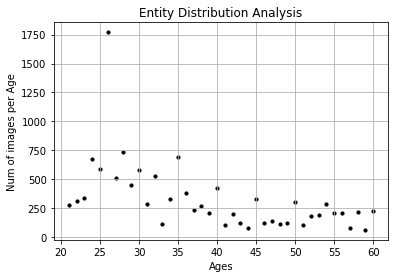

Label		Age		Count
0 		 21 		 280
1 		 22 		 315
2 		 23 		 338
3 		 24 		 677
4 		 25 		 593
5 		 26 		 1770
6 		 27 		 510
7 		 28 		 732
8 		 29 		 447
9 		 30 		 584
10 		 31 		 287
11 		 32 		 526
12 		 33 		 113
13 		 34 		 334
14 		 35 		 692
15 		 36 		 382
16 		 37 		 233
17 		 38 		 271
18 		 39 		 212
19 		 40 		 424
20 		 41 		 102
21 		 42 		 202
22 		 43 		 122
23 		 44 		 82
24 		 45 		 334
25 		 46 		 125
26 		 47 		 139
27 		 48 		 117
28 		 49 		 120
29 		 50 		 305
30 		 51 		 105
31 		 52 		 186
32 		 53 		 195
33 		 54 		 291
34 		 55 		 211
35 		 56 		 207
36 		 57 		 76
37 		 58 		 216
38 		 59 		 63
39 		 60 		 229


In [20]:
dataset_analysis(train_dataset.y, age_label_diff=21)

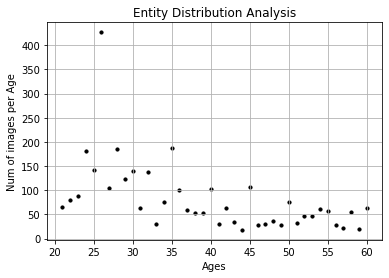

Label		Age		Count
0 		 21 		 66
1 		 22 		 80
2 		 23 		 88
3 		 24 		 182
4 		 25 		 141
5 		 26 		 427
6 		 27 		 105
7 		 28 		 186
8 		 29 		 123
9 		 30 		 140
10 		 31 		 63
11 		 32 		 138
12 		 33 		 30
13 		 34 		 75
14 		 35 		 188
15 		 36 		 101
16 		 37 		 60
17 		 38 		 54
18 		 39 		 54
19 		 40 		 102
20 		 41 		 30
21 		 42 		 64
22 		 43 		 35
23 		 44 		 18
24 		 45 		 106
25 		 46 		 28
26 		 47 		 31
27 		 48 		 36
28 		 49 		 28
29 		 50 		 76
30 		 51 		 33
31 		 52 		 46
32 		 53 		 46
33 		 54 		 62
34 		 55 		 57
35 		 56 		 29
36 		 57 		 21
37 		 58 		 55
38 		 59 		 19
39 		 60 		 64


In [21]:
dataset_analysis(test_dataset.y, age_label_diff=21)

In [22]:
torch.from_numpy(train_dataset.y).bincount()

tensor([ 280,  315,  338,  677,  593, 1770,  510,  732,  447,  584,  287,  526,
         113,  334,  692,  382,  233,  271,  212,  424,  102,  202,  122,   82,
         334,  125,  139,  117,  120,  305,  105,  186,  195,  291,  211,  207,
          76,  216,   63,  229])

In [23]:
torch.from_numpy(test_dataset.y).bincount()

tensor([ 66,  80,  88, 182, 141, 427, 105, 186, 123, 140,  63, 138,  30,  75,
        188, 101,  60,  54,  54, 102,  30,  64,  35,  18, 106,  28,  31,  36,
         28,  76,  33,  46,  46,  62,  57,  29,  21,  55,  19,  64])

# Dataset spliting into train and valid set

In [24]:
valid_size = round(len(train_dataset)*20*0.01) # 20% from train_dataset
train_size = len(train_dataset)-valid_size
print(train_size, valid_size)

train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

10518 2629


In [25]:
# type(list(train_dataset)),type(valid_dataset),type(test_dataset)
# test_dataset.y
# train_dataset.dataset.y
# valid_dataset.dataset.y

In [26]:
len(train_dataset),len(valid_dataset), len(test_dataset)

(10518, 2629, 3287)

# Dataset Loader

In [27]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS)

In [28]:
valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False, # False
                          num_workers=NUM_WORKERS)

In [29]:
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=NUM_WORKERS)

In [30]:
len(train_loader),     len(valid_loader),       len(test_loader)
# (42, 256, 3, 120,120)  (11, 256, 3, 120,120)  (13, 256, 3, 120,120)

(42, 11, 13)

# Model

### ResNet34

In [31]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
    
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

`nn.RELU(inplace=True)` [details](https://discuss.pytorch.org/t/whats-the-difference-between-nn-relu-and-nn-relu-inplace-true/948)

Understanding the underscore( _ ) of Python [link](https://stackoverflow.com/questions/8689964/why-do-some-functions-have-underscores-before-and-after-the-function-name)

`self.modules()` [link](https://discuss.pytorch.org/t/pytorch-self-module/49677)

What do `*` and `**` before a variable name mean in a function signature? [link](https://stackoverflow.com/questions/11315010/what-do-and-before-a-variable-name-mean-in-a-function-signature)

In [32]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(4)
        self.fc = nn.Linear(512, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)

        x = x.view(x.size(0), -1) # reshaping, -1 means calculate the suitable number for second dimension 
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [33]:
def resnet34(num_classes, grayscale):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   grayscale=grayscale)
    return model

### VGG/DEX

In [34]:
def vgg_block(in_channels, out_channels, more=False):
    blocklist = [
        ('conv1', nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)),
        ('relu1', nn.ReLU(inplace=True)),
        ('conv2', nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)),
        ('relu2', nn.ReLU(inplace=True)),
    ]
    if more:
        blocklist.extend([
            ('conv3', nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)),
            ('relu3', nn.ReLU(inplace=True)),
        ])
    blocklist.append(('maxpool', nn.MaxPool2d(kernel_size=2, stride=2)))
    block = nn.Sequential(OrderedDict(blocklist))
    return block

# VGG16 architecture
class VGG(nn.Module):
    def __init__(self, classes=40, channels=3):
        super().__init__()
        self.conv = nn.Sequential(
            vgg_block(channels, 64),
            vgg_block(64, 128),
            vgg_block(128, 256, True),
            vgg_block(256, 512, True),
            vgg_block(512, 512, True),
        )
        self.fc1 = nn.Sequential(
            # nn.Linear(512*7*7, 4096),
            nn.Linear(512*4*4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5, inplace=True),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5, inplace=True),
        )
        self.cls = nn.Linear(4096, classes)

    def forward(self, x):
        in_size = x.shape[0]
        x = self.conv(x)
        x = x.view(in_size, -1)
        x = self.fc1(x)
        x = self.fc2(x)
        logits = self.cls(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

class Gender(VGG):
    def __init__(self, classes=2, channels=3):
        super().__init__()
        self.cls = nn.Linear(4096, classes)

class VGG_Age(VGG):
    def __init__(self, classes=40, channels=3):
        super().__init__()
        self.cls = nn.Linear(4096, classes)

# Initialise Model & Optimizer

In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
model = resnet34(NUM_CLASSES, GRAYSCALE)
# model = VGG_Age()
# model = models.resnet50(progress= True, num_classes=21)
# model.load_state_dict(checkpoint)

model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

`torch.max()` `returns` highest elements along the dimension and indices of highest values, here we are only interested to the indices of highest elements

In [36]:
def calculate_correct_preds(probas, targets):
  return torch.sum(torch.max(probas, dim = 1)[1] == targets)

In [37]:
def compute_acc(total_num_correct_preds, num_examples):
  return format((total_num_correct_preds/num_examples) * 100.0, '.3f')

# Training

PyTorch Normally add the previously calculated gradient with the current calculated gradient and then updates the weight. But here we don't want it. That's why we made the previously calculted gradient zero while calculating a new one with `optimizer.zero_grad()`

In [ ]:
# samples = next(iter(train_loader))

In [ ]:
# len(samples) # 2
# features = samples[0] # torch.Size([256, 3, 120, 120]),
# targets = samples[1]  # torch.Size([256])
# features.shape[0]

In [ ]:
min_valid_cost = np.inf
start_time = time.time()
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in tqdm(range(num_epochs)):
  train_total_num_correct_preds = valid_total_num_correct_preds = train_num_examples = valid_num_examples = 0
 
  model.train()
  for batch_idx, (features, targets) in enumerate(tqdm(train_loader)):

    targets, features =  targets.to(DEVICE), features.to(DEVICE)

    # FORWARD AND BACK PROP
    logits, probas = model(features)
    cost = F.cross_entropy(logits, targets)
    optimizer.zero_grad()
    cost.backward()

    # UPDATE MODEL PARAMETERS
    optimizer.step()
    
    train_total_num_correct_preds += calculate_correct_preds(probas, targets)
    train_num_examples += targets.size(0) 

  model.eval()
  for i, (features, targets) in enumerate(tqdm(valid_loader)):
    targets, features =  targets.to(DEVICE), features.to(DEVICE)

    logits, probas = model(features)
    cost_valid = F.cross_entropy(logits, targets)

    valid_total_num_correct_preds += calculate_correct_preds(probas, targets)
    valid_num_examples += targets.size(0)

  # LOGGING
  print(f'train_total_num_correct_preds: {train_total_num_correct_preds} | valid_total_num_correct_preds: {valid_total_num_correct_preds}')
  training_acc = compute_acc(train_total_num_correct_preds, train_num_examples)
  valid_acc = compute_acc(valid_total_num_correct_preds, valid_num_examples)

  time_elapsed = format((time.time() - start_time)/60, ".3f")
  str = f'Epoch: {epoch+1}/{num_epochs} | Training Cost: {format(cost, ".3f")} | Training_acc: {training_acc}% | Validation Cost: {format(cost_valid, ".3f")} | Validation_acc: {valid_acc}% Time elapsed: {time_elapsed}min'
  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}\n')

  if min_valid_cost > cost_valid:
    str = f'Validation Cost Decreased({format(min_valid_cost, ".3f")}--->{format(cost_valid, ".3f")}) ---Copying State Dict---\n'
    print(str)
    with open(LOGFILE, 'a') as f: f.write(f'{str}\n')
    min_valid_cost = cost_valid
    best_model_wts = copy.deepcopy(model.state_dict())

with open(LOGFILE, 'a') as f: f.write('\n\n############-------Trainig Completed-------############\n\n')

# Evaluation

In [ ]:
def compute_mae_and_mse(model, data_loader, device):
  mae, mse, num_examples, total_num_correct_preds = 0., 0., 0, 0
  for i, (features, targets) in enumerate(tqdm(data_loader)):
          
    targets, features = targets.to(device), features.to(device)
    logits, probas = model(features)

    _, predicted_labels = torch.max(probas, dim=1)
    # predicted_labels = probas > 0.5
    num_correct_preds = torch.sum(predicted_labels == targets)
    total_num_correct_preds += num_correct_preds
    num_examples += targets.size(0)

    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

  print(f'total_num_correct_preds: {total_num_correct_preds}')
  acc = compute_acc(total_num_correct_preds, num_examples)
  mae = format(mae.float()/num_examples, '.3f')
  mse = format(torch.sqrt(mse.float()/num_examples), '.3f')      

  return mae, mse, acc

In [ ]:
model.load_state_dict(best_model_wts)
model.eval()
with torch.set_grad_enabled(False):  # save memory during inference

  train_mae, train_mse, train_acc = compute_mae_and_mse(model, train_loader, device=DEVICE)
  test_mae, test_mse, test_acc = compute_mae_and_mse(model, test_loader, device=DEVICE)

  str = f'MAE/RMSE/ACC: | Train: {train_mae}/{train_mse}/{train_acc}% | Test: {test_mae}/{test_mse}/{test_acc}%'
  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}\n')

str = f'Total Elapsed Time: {format(((time.time() - start_time)/60), ".3f")} min'
print(str)
with open(LOGFILE, 'a') as f: f.write(f'{str}\n')

# Saving the Model

PyTorch: What's the difference between state_dict and parameters()? [link](https://stackoverflow.com/questions/54746829/pytorch-whats-the-difference-between-state-dict-and-parameters)

In [ ]:
torch.save(model.state_dict(), os.path.join(PATH, 'model.pt'))